# Composite Matrix Material Solver

Solves and plots **cure kinetics** and **viscosity** models for thermoset matrix materials.
Reads material parameters from the JSON data files in `materials/matrices/` and generates
publication-quality plots saved to `images/materials/`.

### Supported Models
- **Cure Kinetics**: Autocatalytic + diffusion model (Kamal-Sourour with diffusion factor)
- **Viscosity**: Castro-Macosko model (Arrhenius + gel-point divergence)

### Usage
Change `MATERIAL_FILE` below to point at any matrix material JSON that contains
`cure_kinetics` and/or `viscosity_model` sections, then **Run All**.

In [1]:
import json
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os

# ──────────────────────────────────────────────
# CONFIGURATION — change this for other materials
# ──────────────────────────────────────────────
MATERIAL_FILE = 'materials/matrices/epoxy-resin-8552-extended.json'
OUTPUT_DIR    = 'images/materials'

# Isothermal cure temperatures to simulate (°C)
TEMPERATURES_C = [150, 160, 170, 180]

# Simulation time span (minutes)
T_END_MIN = 300

# Initial degree of cure (small non-zero to avoid 0^m singularity)
ALPHA_INIT = 0.001

# Universal gas constant
R = 8.314  # J/(mol·K)

In [2]:
# ──────────────────────────────────────────────
# Load material data
# ──────────────────────────────────────────────
with open(MATERIAL_FILE) as f:
    material = json.load(f)

material_name = material['name']
material_id   = material['id']
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f'Loaded: {material_name} ({material_id})')
print(f'Has cure_kinetics:   {"cure_kinetics" in material}')
print(f'Has viscosity_model: {"viscosity_model" in material}')

Loaded: Epoxy Resin 8552 (epoxy-resin-8552)
Has cure_kinetics:   True
Has viscosity_model: True


## 1. Cure Kinetics — Autocatalytic + Diffusion Model

$$\frac{d\alpha}{dt} = A\,\exp\!\left(-\frac{\Delta E}{RT}\right)\,\alpha^{m}\,(1-\alpha)^{n}\;\frac{1}{1+\exp\!\left[C\,(\alpha - \alpha_c(T))\right]}$$

where $\alpha_c(T) = \alpha_{c0} + \alpha_{c1}\,T$.

In [3]:
# ──────────────────────────────────────────────
# Cure kinetics model functions
# ──────────────────────────────────────────────
def load_cure_kinetics(mat):
    """Extract cure kinetics parameters from material dict."""
    ck = mat['cure_kinetics']
    return {
        'A':    ck['preExponentialCoefficient']['value'],
        'dE':   ck['activationEnergy']['value'] * 1000,  # kJ/mol -> J/mol
        'm':    ck['firstExponentialConstant']['value'],
        'n':    ck['secondExponentialConstant']['value'],
        'C':    ck['diffusionConstant']['value'],
        'ac0':  ck['criticalDegreeOfCure']['value'],
        'ac1':  ck['criticalDegreeVariation']['value'],
    }


def cure_rate(t, alpha, T_K, p):
    """Compute dα/dt for the autocatalytic + diffusion model."""
    K       = p['A'] * np.exp(-p['dE'] / (R * T_K))
    alpha_c = p['ac0'] + p['ac1'] * T_K
    f_diff  = 1.0 / (1.0 + np.exp(p['C'] * (alpha - alpha_c)))
    return K * (alpha ** p['m']) * ((1.0 - alpha) ** p['n']) * f_diff


def solve_cure(T_C_list, t_end_s, alpha0, params, n_pts=2000):
    """Solve cure kinetics ODE at each temperature. Returns dict of results."""
    t_eval = np.linspace(0, t_end_s, n_pts)
    results = {}
    for T_C in T_C_list:
        T_K = T_C + 273.15
        sol = solve_ivp(
            cure_rate, (0, t_end_s), [alpha0],
            t_eval=t_eval, args=(T_K, params),
            method='RK45', rtol=1e-8, atol=1e-10
        )
        results[T_C] = {'t': sol.t, 'alpha': sol.y[0]}
    return results

Saved: images/materials/epoxy-resin-8552-cure-characteristics.png


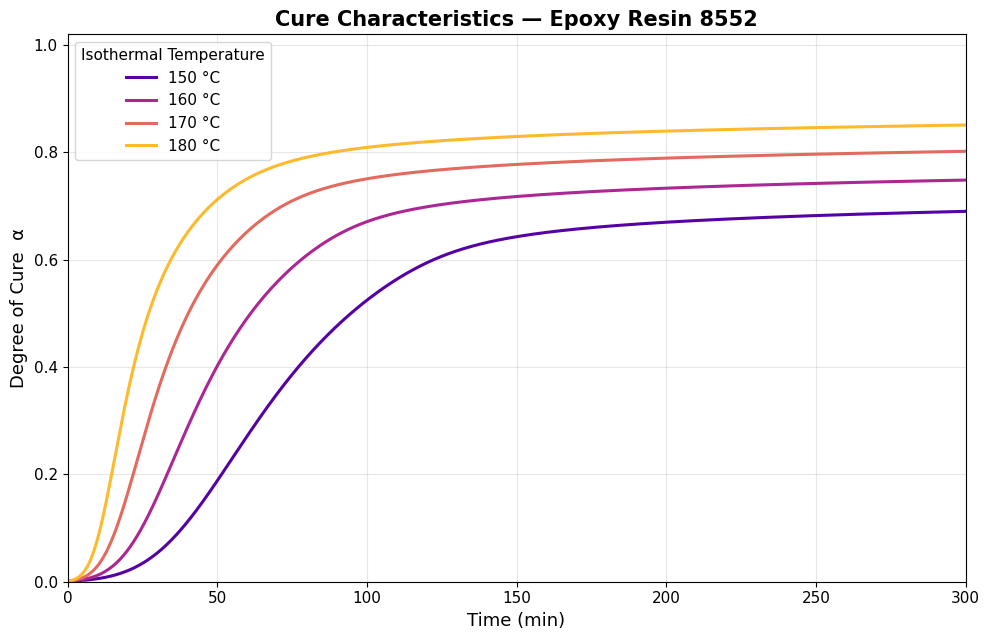

In [4]:
# ──────────────────────────────────────────────
# Solve and plot cure characteristics
# ──────────────────────────────────────────────
ck_params = load_cure_kinetics(material)
cure_results = solve_cure(
    TEMPERATURES_C, T_END_MIN * 60, ALPHA_INIT, ck_params
)

colors = plt.cm.plasma(np.linspace(0.15, 0.85, len(TEMPERATURES_C)))

fig, ax = plt.subplots(figsize=(10, 6.5))
for (T_C, res), color in zip(cure_results.items(), colors):
    ax.plot(res['t'] / 60, res['alpha'], color=color,
            linewidth=2.2, label=f'{T_C} °C')

ax.set_xlabel('Time (min)', fontsize=13)
ax.set_ylabel('Degree of Cure  α', fontsize=13)
ax.set_title(f'Cure Characteristics — {material_name}', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, title='Isothermal Temperature', title_fontsize=11)
ax.set_xlim(0, T_END_MIN)
ax.set_ylim(0, 1.02)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=11)

plt.tight_layout()
cure_path = os.path.join(OUTPUT_DIR, f'{material_id}-cure-characteristics.png')
fig.savefig(cure_path, dpi=150, bbox_inches='tight')
print(f'Saved: {cure_path}')
plt.show()

## 2. Viscosity — Castro-Macosko Model

$$\eta(T,\alpha) = \eta_\infty \,\exp\!\left(\frac{E_\eta}{RT}\right) \left(\frac{\alpha_{\text{gel}}}{\alpha_{\text{gel}} - \alpha}\right)^{A + B\,\alpha}$$

Viscosity diverges as $\alpha \to \alpha_{\text{gel}}$ (gel point).

In [5]:
# ──────────────────────────────────────────────
# Viscosity model functions
# ──────────────────────────────────────────────
def load_viscosity_model(mat):
    """Extract Castro-Macosko viscosity parameters from material dict."""
    vm = mat['viscosity_model']
    return {
        'eta_inf':   vm['eta_inf']['value'],
        'E_eta':     vm['E_eta']['value'],
        'alpha_gel': vm['alpha_gel']['value'],
        'A':         vm['A_visc']['value'],
        'B':         vm['B_visc']['value'],
    }


def viscosity(alpha, T_K, vp):
    """Castro-Macosko viscosity model."""
    eta_0 = vp['eta_inf'] * np.exp(vp['E_eta'] / (R * T_K))
    ratio = vp['alpha_gel'] / (vp['alpha_gel'] - alpha)
    return eta_0 * ratio ** (vp['A'] + vp['B'] * alpha)

Saved: images/materials/epoxy-resin-8552-viscosity-model.png


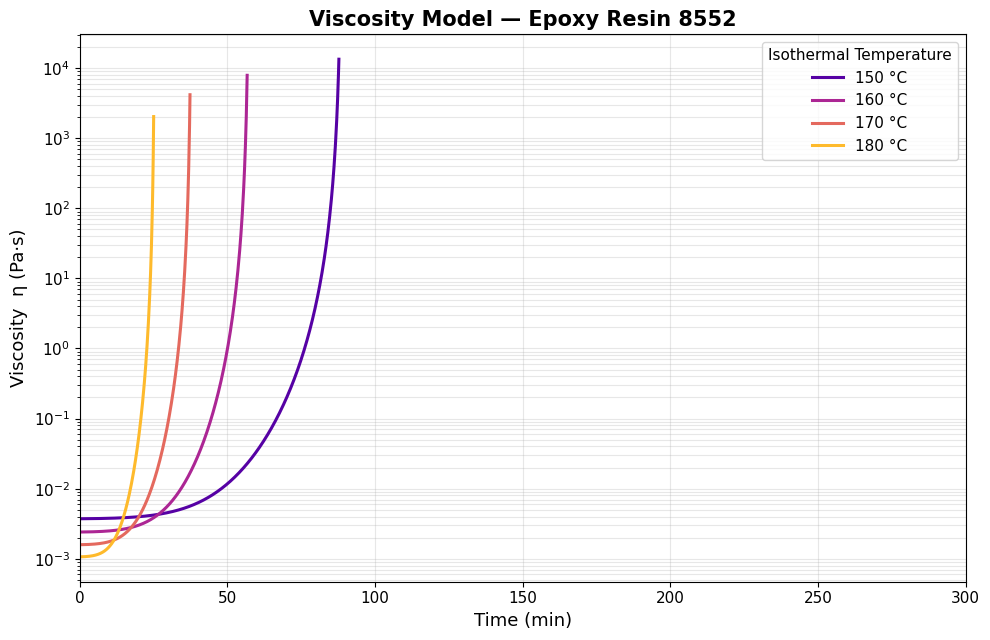

In [6]:
# ──────────────────────────────────────────────
# Compute and plot viscosity during isothermal cure
# ──────────────────────────────────────────────
visc_params = load_viscosity_model(material)

fig, ax = plt.subplots(figsize=(10, 6.5))
for (T_C, res), color in zip(cure_results.items(), colors):
    alpha_vals = res['alpha']
    t_vals     = res['t']
    T_K        = T_C + 273.15

    # Only plot up to near gel point to avoid numerical divergence
    mask = alpha_vals < (visc_params['alpha_gel'] - 0.005)
    eta_vals = viscosity(alpha_vals[mask], T_K, visc_params)

    ax.semilogy(t_vals[mask] / 60, eta_vals, color=color,
                linewidth=2.2, label=f'{T_C} °C')

ax.set_xlabel('Time (min)', fontsize=13)
ax.set_ylabel('Viscosity  η (Pa·s)', fontsize=13)
ax.set_title(f'Viscosity Model — {material_name}', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, title='Isothermal Temperature', title_fontsize=11)
ax.set_xlim(0, T_END_MIN)
ax.grid(True, alpha=0.3, which='both')
ax.tick_params(labelsize=11)

plt.tight_layout()
visc_path = os.path.join(OUTPUT_DIR, f'{material_id}-viscosity-model.png')
fig.savefig(visc_path, dpi=150, bbox_inches='tight')
print(f'Saved: {visc_path}')
plt.show()